## 11. Adaptive radial map stochastic map filter for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [4]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been

In [5]:
using DelimitedFiles

Load some packages to make nice figures

In [6]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [210]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [8]:
Δtdyn = 0.05
Δtobs = 0.4

0.4

Define the time span of interest

In [9]:
t0 = 0.0
tf = 4000.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

10000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [10]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [11]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [12]:
### Process and observation noise
σx = 1e-6
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

In [13]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [14]:
# Time span
tspan = (0.0, tf)

(0.0, 4000.0)

Set initial condition of the true system

In [15]:
x0 = rand(model.π0);

In [16]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [85]:
# Ensemble size
Ne = 160

X0 = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X0, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×160 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 0.0354621   0.136571  -0.871434  1.01892   …  -1.43778   0.951514   0.884698
 2.01645    -1.04806   -1.81428   0.982215     -0.735873  1.48505    0.731567
 0.679222   -0.111855  -1.03683   1.40604       0.501236  1.15227   -1.0118

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [86]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)

Stochastic EnKF  with filtered = false


In [87]:
Xenkf = seqassim(F, data, Tf, model.ϵx, enkf, deepcopy(X0), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


In [88]:
tspin = 1000.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

2500

Time average root-mean-squared error 

In [89]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

1.0692108281291755

Initialize the ensemble matrix for the radial stochastic map filter

In [90]:
Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))
observe(h, Xspin, tspin, Ny, Nx)
ϵy(Xspin, 1, Ny)
Xspin

6×160 Array{Float64,2}:
  3.73146   2.25102   0.146145   2.8297   …  -1.54753   2.89072   0.13446
 13.3375    4.81129   4.48228    8.96264      5.72853   6.96139   4.7746
 27.9605   24.4606   28.8487    29.6017      31.6143   28.166    26.3447
  2.48973   1.60691   0.613738   2.94037      1.18162   1.04032   1.26939
  7.63341   5.91787   6.50447    8.4262       6.16331   6.97294   6.29414
 28.3593   26.57     28.6678    28.0938   …  27.3332   28.3656   27.4226

In [91]:
tsmf = 4000.0
Tsmf = ceil(Int64, (tsmf-tspin)/Δtobs)

7500

Initialize the structure of the map

In [185]:
p = 2
# order = [[-1], [p; p], [-1; p; 0], [-1; p; p; 0]]
order = [[-1], [p; p], [-1; p; 0], [-1; p; p; 0]]

# order = [[-1], [-1; -1], [-1; -1; -1], [p; -1; -1 ;p], [-1; p; -1; p; p], [-1; -1; p; p; p; p]]

# parameters of the radial map
γ = 2.0
λ = 0.0
δ = 1e-8
κ = 10.0
β = 1.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

smf = SparseRadialSMF(x->x, F.h, β, ϵy, order, γ, λ, δ, κ, 
                      Ny, Nx, Ne, 
                      Δtdyn, Δtobs, 
                      dist, idx; islocalized = true)

SparseRadialSMF(var"#67#68"(), h, 1.0, AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 2], [-1, 2, 0], [-1, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, 3, 3, 0.05, 0.4, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false, true, false)

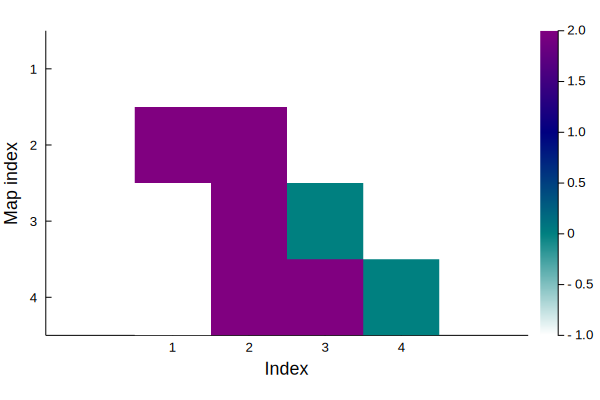

In [186]:
plot(smf.S)

In [189]:
poff = 2
pdiag = 0

γ = 2.0
λ = 0.0
δ = 1e-8
κ = 10.0
β = 1.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

# Sgreedy = SparseRadialMap(Nx+1, -1; λ = λ, δ = δ, γ = γ)
Sgreedy = SparseRadialMap(vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:]), -1; λ = λ, δ = δ, γ = γ)
optimize(Sgreedy, vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:]), poff, [1;0;0], "kfolds";
         apply_rescaling = true, start = 2)

smf_greedy = SparseRadialSMF(x->x, F.h, β, ϵy, Sgreedy,
                      Ny, Nx, 
                      Δtdyn, Δtobs,
                      dist, idx, zeros(Nx+1, Ne), false, true, true)

SparseRadialSMF(var"#71#72"(), h, 1.0, AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 1], [-1, 2, 0], [2, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, 3, 3, 0.05, 0.4, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false, true, true)

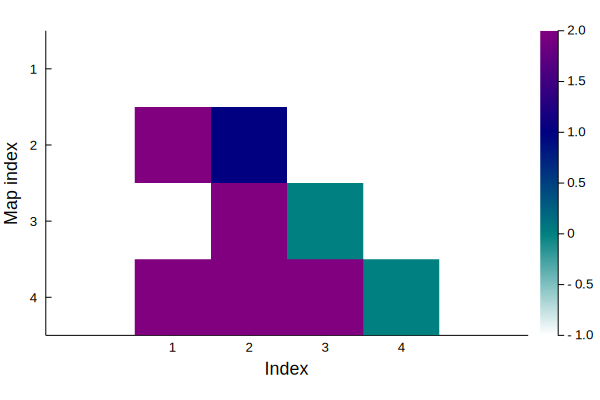

In [202]:
plot(smf_greedy.S)

In [195]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


In [196]:
Xsmf_greedy = seqassim(F, data, Tsmf, model.ϵx, smf_greedy, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:26


In [197]:
rmse_smf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

0.827223314418642

In [198]:
(rmse_enkf-rmse_smf)/rmse_enkf

0.22632347834892855

In [199]:
rmse_greedysmf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf_greedy[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

0.8638542908097336

In [200]:
(rmse_enkf-rmse_greedysmf)/rmse_enkf

0.1920636528520378

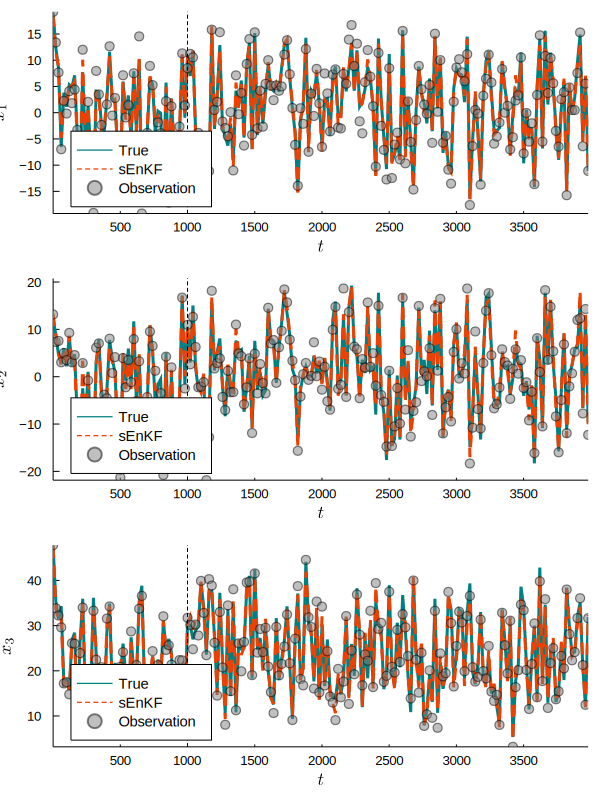

In [201]:
nb = 1
ne = Tspin+Tsmf
Δ = 50
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xenkf[1:Tspin+1], Xsmf_greedy[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash, label = "")
end

plt

### Debugging code

In [306]:
# Define the distribution for initial condition
# Number of runs
Ne = 1000
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz63!,x0, tspan)

X = zeros(1+Nx, Ne) 

@inbounds for i=1:N
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[2:Nx+1,i] = deepcopy(sol.u[1])
end

In [307]:
observe((x,t)->x[1], X, 0.0, 1, Nx)
X[1:1,:] .+= σy*randn(1,Ne)

1×1000 view(::Array{Float64,2}, 1:1, :) with eltype Float64:
 -9.82905  13.6385  -1.49476  -8.82182  …  2.08322  -5.25244  4.05425

In [308]:
Xtrain = copy(X[:,1:500])
Xtest = copy(X[:,501:end])

4×500 Array{Float64,2}:
 10.5311   -2.66139   -4.51587   -9.79143  …   2.08322  -5.25244    4.05425
 11.7826    2.06448   -6.98998  -10.8623       1.49783  -4.8725     6.19798
  5.60885   3.90323  -10.7037    -1.6583       1.45896  -0.110765  11.0344
 37.0186   20.9125    18.6131    38.2468      18.5142   29.1739    12.6804

In [309]:
S = SparseRadialMap(Xtrain, -1; λ = λ, δ = δ, γ = γ)

Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [-1, -1], [-1, -1, -1], [-1, -1, -1, -1]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)


In [310]:
L = LinearTransform(Xtrain)

LinearTransform(4, [0.022357738494262383, -0.03491758974767835, 0.10406676149639485, 23.633303244572485], [8.04919961958128 0.0 0.0 0.0; 0.0 7.779618043277736 0.0 0.0; 0.0 0.0 8.906801703371908 0.0; 0.0 0.0 0.0 8.335317125145323], true)

In [311]:
C = SparseRadialMapComponent(Nx+1, -1)

Sparse radial map component of dimension 4 and order p = [-1, -1, -1, -1]


In [312]:
C, _ = greedyfit(Nx+1, 2, 0, transform(L, Xtrain), transform(L, Xtest), 4, λ, δ, γ; verbose = true)

1 active dimensions  - Training error: 0.498998988674657, Validation error: 0.4970732653868825
dJ_dim = [9.757906893566368e-5, 0.00027737153889012604, 5.2743135772847615e-6]
offdims = [2]
2 active dimensions  - Training error: 0.25624069125359455, Validation error: 0.2516321061591254
dJ_dim = [8.922068684585863e-5, 0.00388182650516233]
offdims = [2, 3]
3 active dimensions  - Training error: -0.24443476181090706, Validation error: -0.20354462538203943
dJ_dim = [0.0002037238501513026]
offdims = [2, 3, 1]
4 active dimensions  - Training error: -0.2559205064712548, Validation error: -0.21696122550217836


(Sparse radial map component of dimension 4 and order p = [2, 2, 2, 0]
, ([0.498998988674657, 0.25624069125359455, -0.24443476181090706, -0.2559205064712548], [0.4970732653868825, 0.2516321061591254, -0.20354462538203943, -0.21696122550217836]))

In [314]:
negative_likelihood(C, transform(L, Xtest), λ, δ)

-0.21696122550217836

In [315]:
negative_likelihood(C, transform(L, Xtrain), λ, δ)

-0.2559205064712548

In [316]:
Sxtrain = S(Xtrain; apply_rescaling = true)

4×500 Array{Float64,2}:
 -1.2239    1.69162   -0.18848    …   1.07968   -1.95356   -0.0594403
 -1.64297   1.70809   -0.0407643      1.01178   -1.87871    0.199243
 -1.65387   1.7102    -0.106695      -0.311092  -2.60727    0.171127
  0.843832  0.881905  -0.907928       1.51433    0.140894  -0.677564

In [317]:
Sxtest = S(Xtest; apply_rescaling = true)

4×500 Array{Float64,2}:
 1.30557   -0.333418  -0.563812  …   0.256033  -0.655319    0.500906
 1.51904    0.269859  -0.894011      0.197021  -0.621828    0.801183
 0.618043   0.426547  -1.21343       0.152119  -0.0241199   1.22719
 1.60585   -0.326423  -0.602278     -0.614141   0.664717   -1.31403

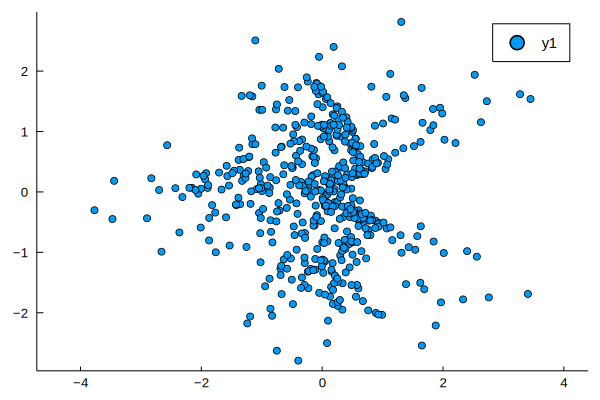

In [263]:
scatter(Sxtrain[4,:], Sxtrain[3,:], ratio = 1.0)

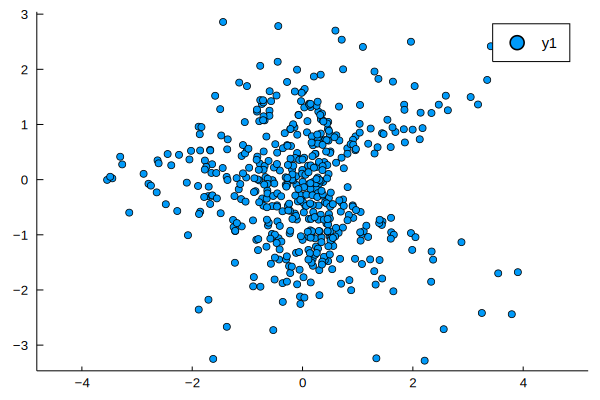

In [264]:
scatter(Sxtest[4,:], Sxtest[3,:], ratio = 1.0)

In [133]:
Xtest = vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:])
scatter(Xtest[1,:], Xtest[3,:], ratio = 1, legend =false)

@show norm(Xtest)
Sgreedy = SparseRadialMap(Xtest, -1; λ = λ, δ = δ, γ = γ)
@show norm(Xtest)

Sgreedy.L.L.diag - std(Xtest; dims = 2)[:,1]

@show norm(Xtest)
optimize(Sgreedy, Xtest, poff, [2;0;0], "kfolds";
         apply_rescaling = true, start = 2)
@show norm(Xtest)
Sx = deepcopy(Sgreedy(Xtest; apply_rescaling = true, start = 2))
@show norm(Xtest)

scatter(Xtest[2,:], Xtest[4,:], legend = false)

ystar = [2.5]

Xpost = deepcopy(Xtest)
inverse!(Xpost, Sx, Sgreedy, ystar; apply_rescaling = true)

norm(Sgreedy(vcat(ystar[1]*ones(1, Ne), Xpost[2:4,:]))[2:4,:]-Sx[2:4,:])

4×160 Array{Float64,2}:
  3.73146   2.25102   0.146145   2.8297   …  -1.54753   2.89072   0.13446
  2.48973   1.60691   0.613738   2.94037      1.18162   1.04032   1.26939
  7.63341   5.91787   6.50447    8.4262       6.16331   6.97294   6.29414
 28.3593   26.57     28.6678    28.0938      27.3332   28.3656   27.4226